In [50]:
import numpy as np
from cgp.graph import Graph
from cgp.population import Population
from automata import CA_2D_model
from bw_images import *
from arg_parser import parse_args

In [51]:
from time import sleep, time
from ipycanvas import Canvas, hold_canvas
import dill

In [52]:
POPULATION = 128
APPLY_SOBEL_FILTER = False
VISION = 1
N_TOTAL_STEPS = 20
GENS = 50
SAVETO = None
RENDER = False
EXTRA_LAYERS = 1
GEN_CHAMPIONS = 64
FITNESS_GOAL = 0

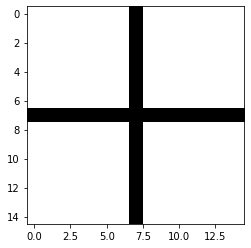

In [53]:
img_size = 15
# TARGET_IMG = column_img(img_size)
TARGET_IMG = plus_img(img_size)
# TARGET_IMG = degrade_img(img_size)
# TARGET_IMG = one_color_img(img_size, 0)
# TARGET_IMG = x_img(img_size)
# TARGET_IMG = diagonal_img(img_size)
# TARGET_IMG = load_emoji(command_line_args.img)
print_img(TARGET_IMG)

In [54]:
input_size = (VISION+2)**2
if APPLY_SOBEL_FILTER:
    input_size *= 3

In [55]:
import networkx as nx
def draw_graph(gr, only_active = True):
    plt.rcParams["figure.figsize"] = (15,20)
    graph = nx.Graph()
    pos = {}
    labels = {}
    color_dict = {
        0: "tab:purple",
        1: "tab:red",
        3: "tab:olive",
        2: "tab:orange",
        4: "tab:green",
        5: "tab:blue",
    }

    col_num = len(gr.columns) - 1
    for col in reversed(gr.columns):
        row = 0
        for n_id in col:
            node = gr.nodes[n_id]
            if only_active and not node.active:
                continue
            pos[node.id] = (col_num, row)

            if col_num == 0:
                labels[node.id] = "In_" + str(row)
            elif col_num == len(gr.columns)-1:
                labels[node.id] = "Out_" + str(row)
            elif node.operation != None:
                labels[node.id] = node.operation.string
            
            graph.add_node(node.id)
            for input in node.inputs:
                graph.add_edge(input, node.id, color=color_dict[col_num%len(color_dict)])
    
            row += 1
        col_num -= 1
    
    options = {
        "font_size": 12,
        "node_size": 1800,
        "node_color": "white",
        "edgecolors": "black",
        "edge_color": nx.get_edge_attributes(graph,'color').values(),
        "linewidths": 2,
        "width": 2,
        "labels": labels,
        "pos": pos
    }
    nx.draw_networkx(graph, **options)
#     nx.draw_networkx(graph, pos)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()

In [56]:
seed = 2002
Graph.rng = np.random.RandomState(seed)

In [57]:
# addition = lambda x, y: x+y
# multiplication = lambda x, y: x*y
# subtraction = lambda x, y: x-y
# constant = lambda x: x
# protected_div = lambda x, y: 1 if y == 0 else x/y
# increment = lambda x: x+1
# invert = lambda x: -x

# Population.add_operation(arity=1, func=lambda x: 1, string="1")
# Population.add_operation(arity=1, func=lambda x: .5, string="0.5")
# Population.add_operation(arity=1, func=lambda x: .1, string="0.1")
# Population.add_operation(arity=1, func=constant, string="x")
# Population.add_operation(arity=1, func=increment, string="x+1")
# Population.add_operation(arity=1, func=invert, string="-x")
# Population.add_operation(arity=2, func=addition, string="x+y")
# Population.add_operation(arity=2, func=multiplication, string="x*y")
# Population.add_operation(arity=2, func=subtraction, string="x-y")
# Population.add_operation(arity=2, func=protected_div, string="*x/y")

In [58]:
def op_and(*args):
    for inp in args:
        if inp == WHITE:
            return WHITE
    return BLACK

def op_or(*args):
    for inp in args:
        if inp == BLACK:
            return BLACK
    return WHITE

def op_xor(*args):
    cont = 0
    for inp in args:
        if inp == BLACK:
            cont += 1
    if cont == 0 or cont == len(args):
        return WHITE
    return BLACK

def op_nand(*args):
    for inp in args:
        if inp == WHITE:
            return BLACK
    return WHITE

def op_nor(*args):
    for inp in args:
        if inp == BLACK:
            return WHITE
    return BLACK

def op_not(x):
    if x == WHITE:
        return BLACK
    else:
        return WHITE

def cte(x):
    return x

In [59]:
for i in range(2, 9):
    Population.add_operation(arity=i, func=op_and, string=("and"+str(i)))
    Population.add_operation(arity=i, func=op_or, string=("or"+str(i)))
    Population.add_operation(arity=i, func=op_xor, string=("xor"+str(i)))
    Population.add_operation(arity=i, func=op_nand, string=("nand"+str(i)))
    Population.add_operation(arity=i, func=op_nor, string=("nor"+str(i)))
Population.add_operation(arity=1, func=op_not, string="not")
Population.add_operation(arity=1, func=cte, string="cte")

Operation 'and2' already exists, overwrinting old operation
Operation 'or2' already exists, overwrinting old operation
Operation 'xor2' already exists, overwrinting old operation
Operation 'nand2' already exists, overwrinting old operation
Operation 'nor2' already exists, overwrinting old operation
Operation 'and3' already exists, overwrinting old operation
Operation 'or3' already exists, overwrinting old operation
Operation 'xor3' already exists, overwrinting old operation
Operation 'nand3' already exists, overwrinting old operation
Operation 'nor3' already exists, overwrinting old operation
Operation 'and4' already exists, overwrinting old operation
Operation 'or4' already exists, overwrinting old operation
Operation 'xor4' already exists, overwrinting old operation
Operation 'nand4' already exists, overwrinting old operation
Operation 'nor4' already exists, overwrinting old operation
Operation 'and5' already exists, overwrinting old operation
Operation 'or5' already exists, overwrin

In [60]:
def eval_individual(individual: Graph, target_image, layers, render=False):
    shape = target_image.shape
    ca = CA_2D_model(shape[0], shape[1], individual.operate, layers)
    
    total_fitness = 0.0
    ca.reset_ca()

    for _ in range(N_TOTAL_STEPS):
        if render:
            print(ca.fitness(target_image)/(255*255))
            print_img(ca.remove_pad())
        update = ca.update()
        if not update: # the automata got stable
            break
    if ca.ca[0, :, :].sum() >= ca.len*ca.len*255:
        return 1000
    total_fitness += ca.fitness(target_image)/(255*255)

    fitness = (total_fitness) 
    return fitness

In [61]:
def test_image(target_img, test_name, fit_func, report_interval = 10):
    print("******************************** ", test_name," ****************************")
    # def fit_func(x):
    #     return eval_individual(x, target_img, total_layers)

    # test_images.print_img(TARGET_IMG)
    total_layers = 1 + EXTRA_LAYERS
    input_size = (VISION+2)**2

    population = Population(
        population_size=POPULATION,
        n_in=total_layers*input_size,
        n_out=total_layers,
        n_row=2,
        n_col=4,
        levels_back=5,
        mutation_strategy="point",
        fitness_func=fit_func,
        minimize_fitness=True,
        point_mut_qnt=8,
        prob_mut_chance=.25,
        mutate_active_only=False
    )

    start = time()
    population.one_plus_lamda(GENS, GEN_CHAMPIONS, FITNESS_GOAL, report=report_interval)
    end = time()
    print("Execution time: ", end - start)
    population.save_pop(test_name+"3.pkl")

In [62]:
# test_images.print_img(TARGET_IMG)
total_layers = 1 + EXTRA_LAYERS
def fit_func(x):
    return eval_individual(x, plus_img(img_size), total_layers)
population = Population(
    population_size=POPULATION,
    n_in=total_layers*input_size,
    n_out=total_layers,
    n_row=6,
    n_col=8,
    levels_back=8,
    mutation_strategy="point",
    fitness_func=fit_func,
    minimize_fitness=True,
    point_mut_qnt=32,
    prob_mut_chance=.1,
    mutate_active_only=False
)

2


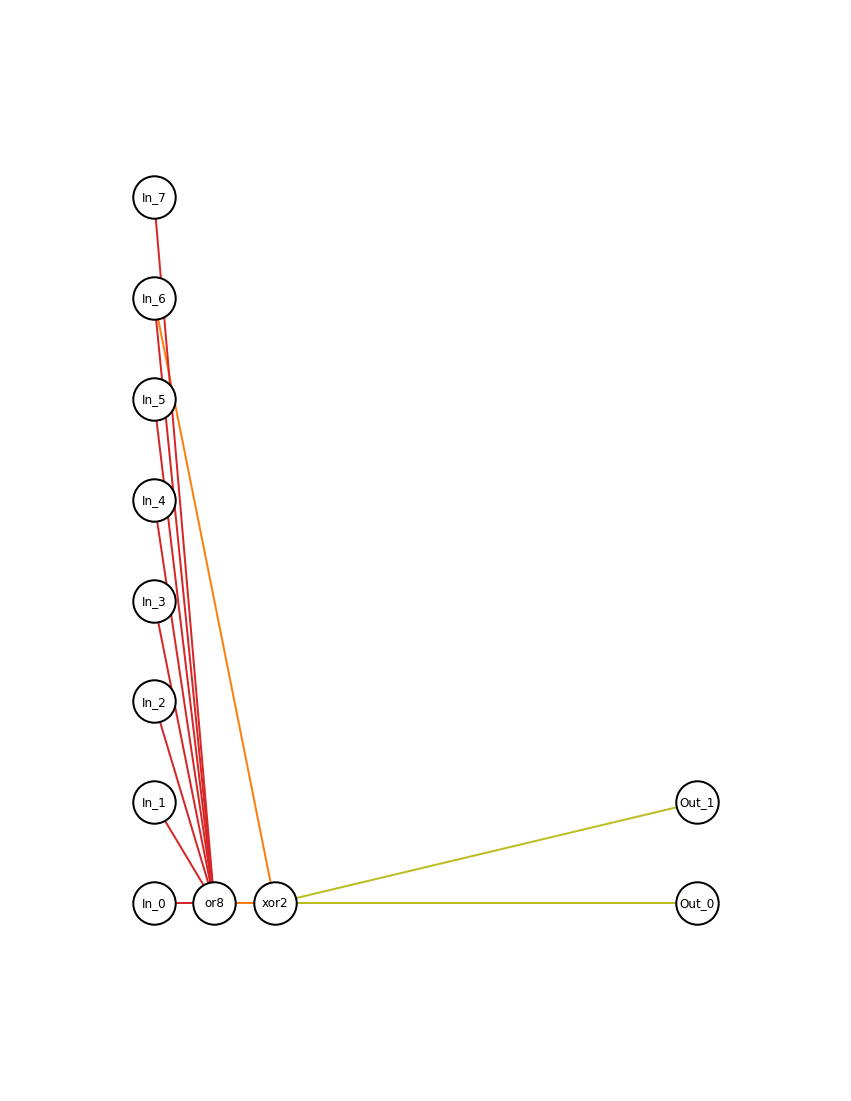

In [63]:
print(total_layers)
draw_graph (population.indvs[2], True)
population.save_pop("aaa.pkl")

In [ ]:

start = time()
population.one_plus_lamda(500, GEN_CHAMPIONS, FITNESS_GOAL, report = 1)
end = time()
print("Execution time: ", end - start)

generation  0 :  21.0
generation  1 :  21.0
generation  2 :  21.0
generation  3 :  21.0
generation  4 :  14.0
generation  5 :  14.0
generation  6 :  14.0
generation  7 :  14.0
generation  8 :  14.0
generation  9 :  14.0
generation  10 :  14.0
generation  11 :  14.0
generation  12 :  14.0
generation  13 :  14.0
generation  14 :  14.0
generation  15 :  14.0
generation  16 :  14.0
generation  17 :  14.0
generation  18 :  14.0
generation  19 :  14.0
generation  20 :  14.0
generation  21 :  14.0
generation  22 :  14.0
generation  23 :  14.0
generation  24 :  14.0
generation  25 :  14.0
generation  26 :  14.0
generation  27 :  14.0
generation  28 :  14.0
generation  29 :  14.0
generation  30 :  14.0
generation  31 :  14.0
generation  32 :  14.0
generation  33 :  14.0
generation  34 :  14.0
generation  35 :  14.0
generation  36 :  14.0
generation  37 :  14.0
generation  38 :  14.0
generation  39 :  14.0
generation  40 :  14.0
generation  41 :  14.0
generation  42 :  14.0
generation  43 :  14.

In [76]:
population.save_pop("aaa.pkl")
def scale_matrix(matrix, scale):
    return np.kron(matrix, np.ones((scale,scale)))

def animate_individual(individual, steps, scale, t):
    shape = TARGET_IMG.shape
    ca = CA_2D_model(shape[0], shape[1], individual.operate, 1 + EXTRA_LAYERS)

    canvas = Canvas(width=TARGET_IMG.shape[0]*scale, height=TARGET_IMG.shape[1]*scale)
    canvas
    for i in range(steps):
        with hold_canvas(canvas):
            # Clear the old animation step
            canvas.clear()
            # Perfom all your drawings here
            img = scale_matrix(ca.remove_pad(), scale)
            _ = canvas.put_image_data(img, 0, 0)

            update = ca.update()
            print_img(img)
            if not update: # the automata got stable
                break

        # Animation frequency ~50Hz = 1./50. seconds
        sleep(t)

In [67]:

hof = population.get_best_indvs(16)
for ind in hof:
    print(ind.fitness)

21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0
21.0


28.0


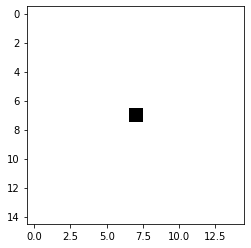

27.0


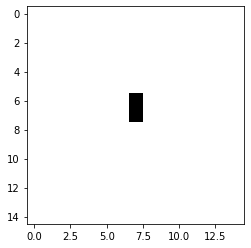

26.0


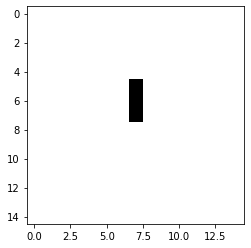

25.0


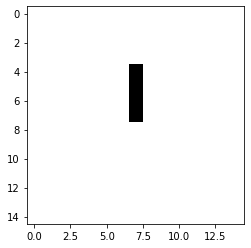

24.0


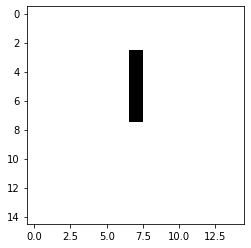

23.0


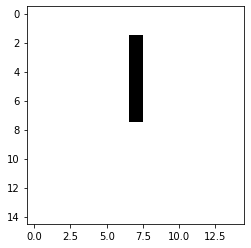

22.0


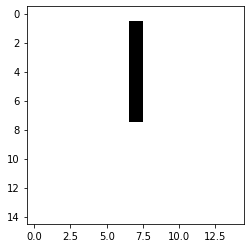

21.0


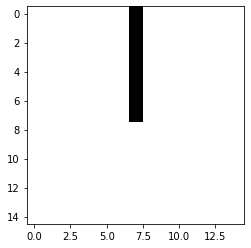

21.0


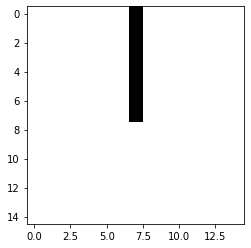

21.0


In [73]:
print(eval_individual(hof[0], TARGET_IMG, total_layers, True))


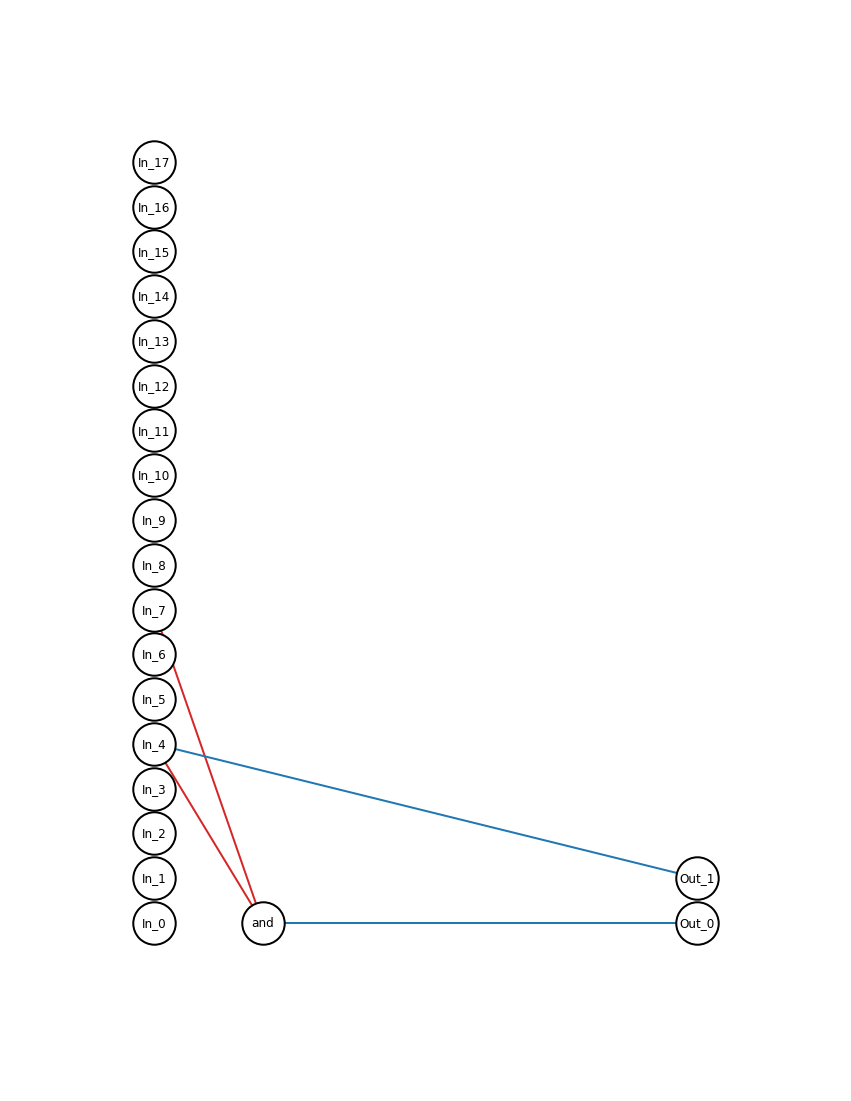

In [74]:
draw_graph (hof[0])

In [28]:
canvas = Canvas(width=TARGET_IMG.shape[0]*4, height=TARGET_IMG.shape[1]*4)
canvas

Canvas(height=60, width=60)

In [4]:
import pickle
with open("checkboard.pkl", 'rb') as pickle_file:
    pop = pickle.load(pickle_file)


AttributeError: Can't get attribute 'fit_func_checkboard_img' on <module '__main__'>